# Bakery Sales Project
Deep Learning Project in python to predict the sales for a bakery using historical data from the Sales dataset of 6 products. The sales dataset for daily sales used in this project spans over a period of 6 years from 2013 to 2018. The purpose of this project is to develop a predictive model and predict the expected sales for the bakery at any given date(s) in future. This project features exploratory analysis and the model is based on feed forward neural network.
Note: the data for this project is private and cannot be shared, only the results are made available.

## Participants:

1. Johannes Dupont
2. Pavan Jethvani
3. Osama Alrabayah
4. Jannik Knopp

### Course and Semester
Deep Learning from Scratch Summer Semester 2021

### Tools
#### External Tools

1. Jupyter Notebook
2. Google Colab

#### Python Modules

1. Tensorflow and Keras
2. Keras Tuner
3. pandas and numpy
4. seaborn and matplotlib
5. sklearn(shuffle and train_test_split)


In [ ]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.layers.experimental import preprocessing

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from keras.callbacks import TensorBoard, EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
# Loading the data
path = os.path.join(os.getcwd(), "data")
sales = pd.read_csv(os.path.join(path, "sales.csv"))
wheather = pd.read_csv(os.path.join(path, "wheather.csv"))
kiwo = pd.read_csv(os.path.join(path, "kiwo.csv") )

# Merge Data to one table
concat_data = pd.merge(sales, wheather, on=["Date"]) 

In [ ]:
# convert date to Day, weekday, month, year
concat_data.Date=pd.to_datetime(concat_data.Date)
concat_data['Date'] = pd.to_datetime(concat_data['Date'], errors = 'coerce')
concat_data['Year'] = concat_data['Date'].dt.year
concat_data['Month'] = concat_data['Date'].dt.month
concat_data['Day'] = concat_data['Date'].dt.day
concat_data['Day_of_week'] = concat_data['Date'].dt.weekday
concat_data=concat_data[['Date','Year','Day_of_week','Month','Day','Group',
                         'Cloudiness','Temperature','Wind Speed','Weather Code','Sales']]

### Data Insights

In [ ]:
concat_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,10788.0,2015.927790,1.753323,2013.000000,2014.000000,2016.000000,2017.00000,2019.000000
Day_of_week,10788.0,2.997126,2.000114,0.000000,1.000000,3.000000,5.00000,6.000000
Month,10788.0,6.642937,3.516118,1.000000,4.000000,7.000000,10.00000,12.000000
Day,10788.0,15.721264,8.755344,1.000000,8.000000,16.000000,23.00000,31.000000
Group,10788.0,3.091491,1.490637,1.000000,2.000000,3.000000,4.00000,6.000000
Cloudiness,10734.0,4.732159,2.653100,0.000000,3.000000,6.000000,7.00000,8.000000
Temperature,10788.0,11.794288,7.147310,-8.475000,6.100000,11.250000,17.62500,32.671428
Wind Speed,10788.0,10.998331,4.141871,3.000000,8.000000,10.000000,13.00000,35.000000
Weather Code,8277.0,36.157062,27.043763,0.000000,10.000000,22.000000,61.00000,95.000000
Sales,10788.0,206.495317,142.922151,7.051201,97.362053,162.953749,280.66877,1879.461831


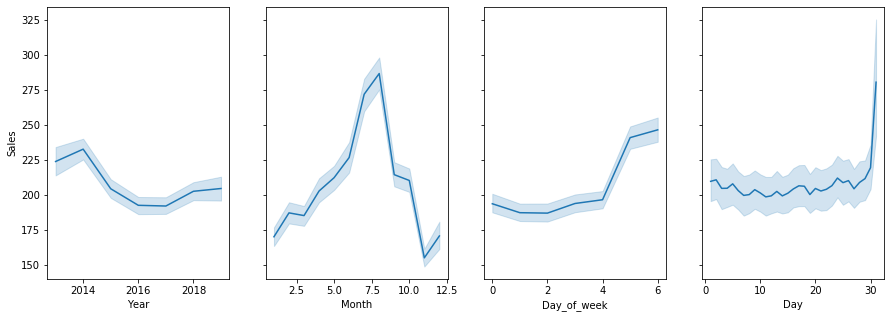

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
sns.lineplot(ax=axes[0], x=concat_data['Year'], y=concat_data['Sales'])
sns.lineplot(ax=axes[1], x=concat_data['Month'], y=concat_data['Sales'])
sns.lineplot(ax=axes[2], x=concat_data['Day_of_week'], y=concat_data['Sales'])
sns.lineplot(ax=axes[3], x=concat_data['Day'], y=concat_data['Sales'])

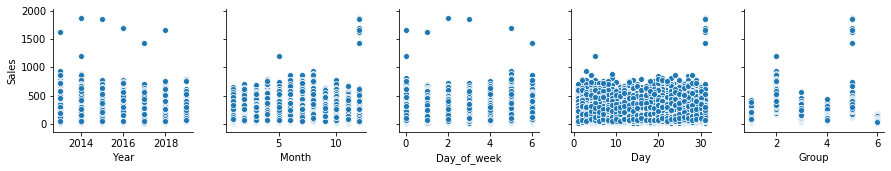

In [ ]:
sns.pairplot(concat_data, y_vars=["Sales"], x_vars=['Year','Month','Day_of_week', 'Day', 'Group'], diag_kind='kde')

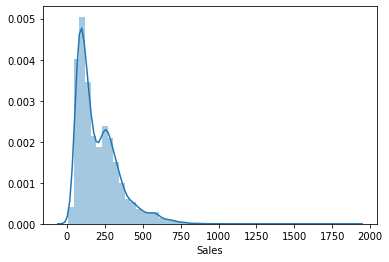

In [ ]:
sns.distplot(concat_data["Sales"])

### Data Preprocessing
After taking a closer look to the data we tried to clear the unsuable data and convert some features to be more fitting for a neural network.
We have done the following steps:
1. Remove all NaNs
2. Remove data that is not needed (or which was later seen that is was not giving an improvement)
3. Remove outliers of the sales data
4. One Hot Encoding of categorical features

In [ ]:
# remove weather code because a quarter of the data contains NaNs
clean_data = concat_data.drop(columns="Weather Code")  
# Remove all data with NaNs
clean_data = clean_data.dropna()

In [ ]:
# Choose the features on which we want to train our model
# remove weather data
#clean_data = clean_data.drop(columns=["Temperature", "Cloudiness", "Wind Speed", "Date"])
clean_data = clean_data.drop(columns=["Date"])

In [ ]:
# calculate distance of every point to the point cloud in stadard deviations
std = clean_data["Sales"].std()
mean = clean_data["Sales"].mean()

clean_data["Sales std"] = (clean_data["Sales"] - mean) / std
#  remove all points that have a higher standard deviation of 3.0 => classified as outliers
clean_data.drop(clean_data[clean_data["Sales std"] > 3.0].index, inplace=True)
clean_data = clean_data.drop(columns=["Sales std"])

In [ ]:
# convert categorical features to one hot encoding
clean_data = pd.get_dummies(clean_data, columns=["Month", "Day_of_week", "Group", "Day"])

### Model Architecture


In [ ]:
# shuffle data
shuffled_data = shuffle(clean_data)

# divide into features and labels
Y = shuffled_data.pop("Sales").to_frame()
X = shuffled_data

# separate into train and test set
X_train, X_Test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

In [ ]:
#%pip install -U keras-tuner

In [ ]:
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.layers import Dense, Flatten, Activation
import time

normaliser = preprocessing.Normalization(input_shape=[shuffled_data.shape[1]])
normaliser.adapt(np.array(shuffled_data))

es = EarlyStopping(monitor='val_loss', mode='min', baseline=16)

def build_model(hp):
    model = keras.Sequential()
    model.add((layers.Dense(units=hp.Int('input_units',
                                min_value=64,
                                max_value=1024,
                                step=64), input_shape=shuffled_data.shape[1:], activation='relu')))
    
    for i in range(hp.Int('n_layers', 1, 10)):  # adding variation of layers.
        model.add(layers.Dense(units=hp.Int(f'further_{i}_units', min_value=64, max_value=1024, step=64)))
        model.add(Activation('relu'))
        model.add(layers.Dropout(hp.Float('dropout', 0, 0.2, step=0.05, default=0.2)))
        
    model.add(layers.Dense(1, activation="linear"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3])), loss='mean_absolute_percentage_error', metrics=['mae'])
    
    return model
# uncomment this code to use the tuner (caution this needs several hours!!!)
"""
tuner = RandomSearch(
    build_model,
    objective='mean_absolute_percentage_error',
    max_trials=10,
    executions_per_trial=2,
    project_name = "Bakery-Sales-optimal-Model",
    directory = "models/")

tuner.search(x=X_train,
             y=y_train,
             verbose=1, 
             epochs=60,
             callbacks=es,
             validation_data=(X_Test, y_test))
"""
#tuner.get_best_models()[0].summary()

'\ntuner = RandomSearch(\n    build_model,\n    objective=\'mean_absolute_percentage_error\',\n    max_trials=10,\n    executions_per_trial=2,\n    project_name = "Bakery-Sales-optimal-Model",\n    directory = "models/")\n\ntuner.search(x=X_train,\n             y=y_train,\n             verbose=1, \n             epochs=60,\n             callbacks=es,\n             validation_data=(X_Test, y_test))\n'

#### Optimal Hyperparameters

| Layer       | Number of Neurons | Activation Function |
| ----------- | ----------------- | ------------------- |
| 1           | 802               | ReLu                |
| 2           | 382               | ReLu                |
| 3           | 926               | ReLu                |
| 4           | 990               | ReLu                |
| 5           | 510               | ReLu                |
| 6           | 798               | ReLu                |
| 7           | 1                 | Linear              |

|  Method        | Used                |
| -------------- | ------------------- |
| Normalization  | Yes                 |
| Data Shuffling | Yes                 |
| Dropout        | 0.0                 |
| Loss-Function  | mean_absolute_percentage_error |
| Optimizer      | Adam                |
| Learning rate  | 0.001               |

In [ ]:
# needed to get rid of some warnings
tf.keras.backend.set_floatx('float64')

# initializing the normalization layer 
normalizer = preprocessing.Normalization(input_shape=[shuffled_data.shape[1]])
normalizer.adapt(np.array(shuffled_data))
# creation of the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=shuffled_data.shape[1]),
    normalizer,
    tf.keras.layers.Dense(802, activation="relu"),
    tf.keras.layers.Dense(382, activation="relu"), 
    #tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(926, activation="relu"),
    #tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(990, activation="relu"),
    #tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(510, activation="relu"),
    tf.keras.layers.Dense(798, activation="relu"),
    #tf.keras.layers.Dropout(dropout),
    # last layer needs to have linear activation function because we solve a regression problem
    tf.keras.layers.Dense(1, activation="linear")
])

adam = tf.keras.optimizers.Adam(lr=0.001)
# loss function can be changed to another loss function fitting for regression
# mse = mean squared error
model.compile(optimizer=adam, loss='mean_absolute_percentage_error', metrics=["mean_absolute_error"])

# specify steps per epoch for faster convergence and lower training time
# Check other possible parameters like batch size ...
history = model.fit(X_train,y_train, epochs=20, validation_split=0.2)

Epoch 1/20
239/239 [==============================] - 3s 12ms/step - loss: 28.8250 - mean_absolute_error: 56.1725 - val_loss: 20.9473 - val_mean_absolute_error: 37.8662
Epoch 2/20
239/239 [==============================] - 3s 12ms/step - loss: 19.7519 - mean_absolute_error: 36.3778 - val_loss: 19.3548 - val_mean_absolute_error: 34.3089
Epoch 3/20
239/239 [==============================] - 3s 11ms/step - loss: 18.2652 - mean_absolute_error: 33.8527 - val_loss: 22.3310 - val_mean_absolute_error: 36.4764
Epoch 4/20
239/239 [==============================] - 3s 12ms/step - loss: 17.1485 - mean_absolute_error: 31.4138 - val_loss: 20.9404 - val_mean_absolute_error: 39.2573
Epoch 5/20
239/239 [==============================] - 3s 12ms/step - loss: 16.4565 - mean_absolute_error: 30.5531 - val_loss: 18.7136 - val_mean_absolute_error: 33.3025
Epoch 6/20
239/239 [==============================] - 3s 11ms/step - loss: 15.3467 - mean_absolute_error: 28.3600 - val_loss: 18.4049 - val_mean_absolute_e

### Results
In the following section the results for one specific solution followed up with results for different input Data

In [ ]:
# function that plots train and validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 120])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Sales]')
    plt.legend()
    plt.grid(True)

# function that plots a number (dist) of samples and how the prediction of the model is accordning to the correct data
def plot_prediction(pred_data, correct_data, dist):
    plt.plot(pred_data[:dist], label='prediction')
    plt.plot(correct_data[:dist], label='actual data')
    plt.ylim([0, 600])
    plt.xlabel('Datapoint')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)

0.8989100155541629


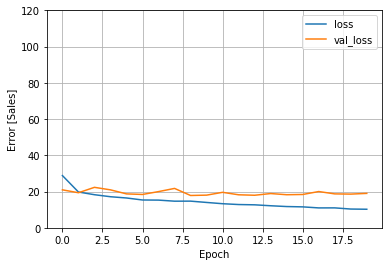

In [ ]:
# plot train and validation loss
plot_loss(history)

predictions = model.predict(X_Test)

# variance score of the data
from sklearn.metrics import explained_variance_score
print(explained_variance_score(y_test, predictions))

34/34 [==============================] - 0s 4ms/step - loss: 18.0765 - mean_absolute_error: 29.5586


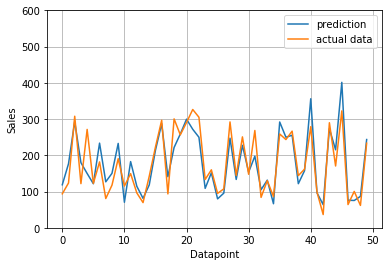

In [ ]:
# plot prediction and correct data
eval_model = model.evaluate(X_Test, y_test) 
plot_prediction(predictions, np.array(y_test), 50)

In [ ]:
### Error Analysis
# compute the error in sales and merge it again with it features
error = np.abs(np.array(y_test) - predictions)
error_data = X_Test.copy()
error_data["Error"] = error
# sort the data according to Error values
error_data.sort_values("Error")

,Year,Cloudiness,Temperature,Wind Speed,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,Error
9743,2018,7.0,8.5375,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.058231
7984,2017,7.0,7.5375,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.133908
5302,2016,5.0,16.7500,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.174357
4186,2015,7.0,7.7500,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.192926
9552,2018,2.0,11.2875,17,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.195164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,2014,4.0,12.7000,14,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,141.555995
6963,2017,7.0,6.8750,7,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,152.488296
4878,2016,7.0,6.8750,12,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,157.376935
1479,2014,5.0,14.4000,14,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,168.305666


### Results for Different Input Data
We tested the model with different input data to check the performance and the quality of different feautres. THese are summarized in the following table. 
The values for the results are taken from the evalutation on the test set.

| Features           | Best Result (%)   | Worst Result (%)    |
| ------------------ | ----------------- | ------------------- |
| Only Time          | 16.93             | 18.21               |
| Only Wheater       | 21.73             | 23.49               |
| Time and Wheater   | 15.97             | 17.62               |

We used early stopping with a value of 16. This had only an effect on the time and wheater data version.

### Weekly Predictions
Unfortunaly we had not enough time to try out this approach but maybe this would be also a valid option with less noise.

### Outlook

#### 1. Change Labels from Sales to Numbers of Articles sold
The sales values are influenced with from discounts and special offers and therefore introduce an initial bias which can't be corrected without additional information. Therefore predicting the number of sold articles would be much more precise and probably also better suited for practical purposes.